In [3]:
import tensorflow as tf
import tensorflow_hub as hub


In [7]:
import tensorflow_text as text

In [31]:
import pandas as pd

df=pd.read_csv('spam.csv',encoding = "ISO-8859-1")
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [32]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [33]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [34]:
df.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

In [35]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [36]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [37]:
747/4825

0.15481865284974095

In [39]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [40]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [44]:
#Down Sampling
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [46]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [47]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [48]:
df_balanced.sample(5)

,Category,Message
1001,spam,Please call our customer service representativ...
4146,ham,Pls help me tell sura that i'm expecting a bat...
1163,ham,"New Theory: Argument wins d SITUATION, but los..."
4022,ham,Well. Balls. Time to make calls
1140,ham,Oh:)as usual vijay film or its different?


In [50]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
1369,ham,Did you try making another butt.,0
931,ham,Congratulations ore mo owo re wa. Enjoy it and...,0
2093,spam,Final Chance! Claim ur å£150 worth of discount...,1
2263,spam,Not heard from U4 a while. Call 4 rude chat pr...,1
1804,ham,The bus leaves at &lt;#&gt;,0
2334,ham,Do you like Italian food?,0
2648,ham,"Hi, can i please get a &lt;#&gt; dollar loan...",0
5492,spam,Marvel Mobile Play the official Ultimate Spide...,1
483,ham,Thank you baby! I cant wait to taste the real ...,0
1268,spam,Can U get 2 phone NOW? I wanna chat 2 set up m...,1


In [53]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])
X_train.head(4)

4164    Dear Voucher Holder, To claim this weeks offer...
958     My sort code is  and acc no is . The bank is n...
1429    For sale - arsenal dartboard. Good condition b...
2271    Life spend with someone for a lifetime may be ...
Name: Message, dtype: object

In [56]:
bert_preprocess=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [57]:
def get_sentence_embeding(sentences):
  preprocessed_text=bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


get_sentence_embeding(["500$ discount.hurry up",
                     "Bhavin, are you up for a volleyball game tomorrow" ])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327276, -0.88845724, ..., -0.7474888 ,
        -0.75314736,  0.91964495],
       [-0.86342734, -0.5988451 , -0.9751756 , ..., -0.91110355,
        -0.72617364,  0.8519889 ]], dtype=float32)>

In [58]:
e=get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [59]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069194, -0.14219394,  0.49604553, ...,  0.42165306,
        -0.5322141 ,  0.8031219 ],
       [-0.86023223, -0.21242952,  0.49156865, ...,  0.39797997,
        -0.6050631 ,  0.84471667],
       [-0.7128861 , -0.15463905,  0.38401675, ...,  0.3527874 ,
        -0.5099133 ,  0.734741  ],
       [-0.8253345 , -0.3555056 , -0.5906967 , ..., -0.01613647,
        -0.6141757 ,  0.87230283],
       [-0.7504135 , -0.2681261 , -0.26689693, ...,  0.02839418,
        -0.59381   ,  0.797499  ],
       [-0.78544354, -0.29949677,  0.4102741 , ...,  0.5222538 ,
        -0.49573544,  0.8150749 ]], dtype=float32)>

In [60]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[3]])

array([[0.84703875]], dtype=float32)

In [65]:
cosine_similarity([e[0]],[e[4]])

array([[0.8933632]], dtype=float32)

In [67]:
#Bert Layers
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#Neural network layers

l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#Construct final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])


In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [69]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precesion'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [70]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 371s 10s/step - loss: 0.6439 - accuracy: 0.6321 - precesion: 0.6498 - recall: 0.5732
Epoch 2/10
35/35 [==============================] - 362s 10s/step - loss: 0.5083 - accuracy: 0.8330 - precesion: 0.8188 - recall: 0.8554
Epoch 3/10
35/35 [==============================] - 361s 10s/step - loss: 0.4362 - accuracy: 0.8536 - precesion: 0.8486 - recall: 0.8607
Epoch 4/10
35/35 [==============================] - 362s 10s/step - loss: 0.3883 - accuracy: 0.8741 - precesion: 0.8682 - recall: 0.8821
Epoch 5/10
35/35 [==============================] - 361s 10s/step - loss: 0.3596 - accuracy: 0.8786 - precesion: 0.8681 - recall: 0.8929
Epoch 6/10
35/35 [==============================] - 362s 10s/step - loss: 0.3405 - accuracy: 0.8875 - precesion: 0.8834 - recall: 0.8929
Epoch 7/10
35/35 [==============================] - 365s 10s/step - loss: 0.3159 - accuracy: 0.9018 - precesion: 0.8906 - recall: 0.9161
Epoch 8/10
35/35 [=======================

In [71]:
model.evaluate(X_test,y_test)


12/12 [==============================] - 124s 10s/step - loss: 0.3121 - accuracy: 0.8930 - precesion: 0.8517 - recall: 0.9519


[0.3121029734611511, 0.893048107624054, 0.8516746163368225, 0.9518716335296631]

In [72]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()


12/12 [==============================] - 130s 11s/step


In [73]:
import numpy as np
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [74]:
from sklearn.metrics import confusion_matrix, classification_report

cm=confusion_matrix(y_test,y_predicted)
cm

array([[156,  31],
       [  9, 178]])

Text(50.722222222222214, 0.5, 'Truth')

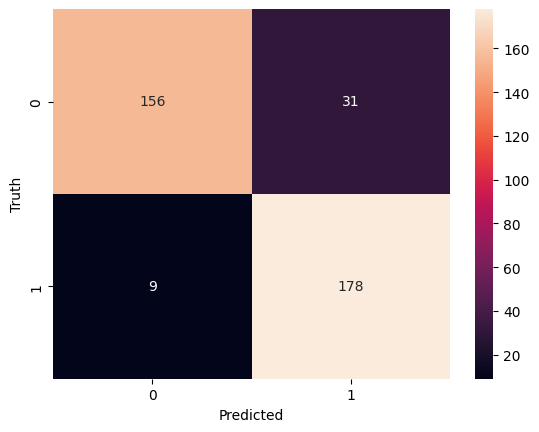

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [76]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       187
           1       0.85      0.95      0.90       187

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374



In [78]:
df.head(15)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [83]:
reviews=[
  'Go until jurong point, crazy.. Available only ...',
  'Free entry in 2 a wkly comp to win FA Cup fina...',
  'WINNER!! As a valued network customer you have...',
  "I've been searching for the right words to tha...",
  'SIX chances to win CASH! From 100 to 20,000 po...',
]

model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.3520816 ],
       [0.2312882 ],
       [0.2804671 ],
       [0.10399497],
       [0.5811036 ]], dtype=float32)